📦 Installing required libraries...


Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.



🔑 UPLOAD 'kaggle.json' (Settings > Create New Token):


Saving kaggle.json to kaggle.json
✅ Kaggle API Authenticated.

⬇️ Downloading APTOS dataset (this may take a few minutes)...
Dataset URL: https://www.kaggle.com/datasets/mariaherrerot/aptos2019
License(s): unknown
✅ Dataset unzipped.

📥 Downloading L-DR-MEP model weights...
🤖 Loading Diffusion components...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

✅ Weights loaded successfully.

🎨 Generating 5x5 Class-wise Preview...


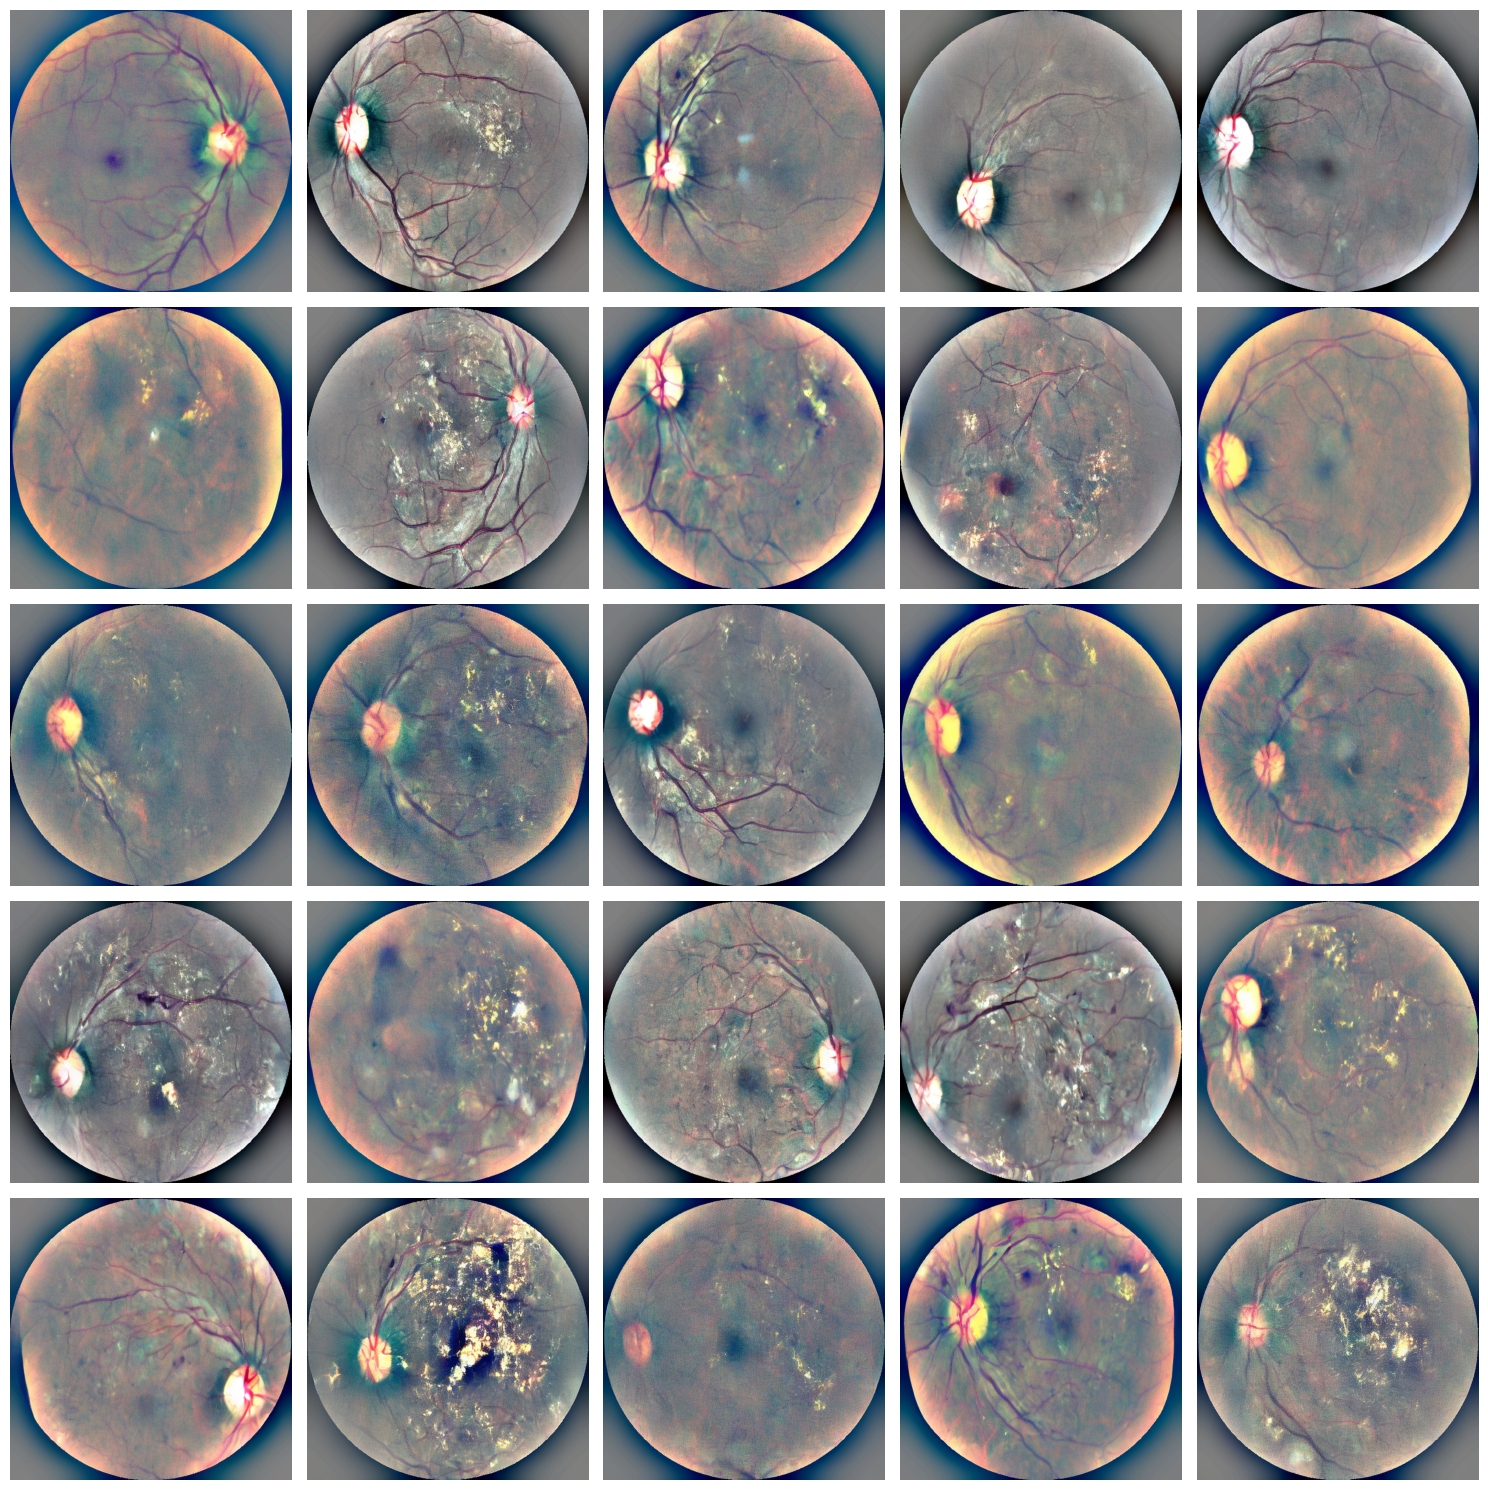


🚀 Starting full 10,000 image generation...
Class 0 (No DR): Val=172, Train=1828


  0%|          | 0/250 [00:00<?, ?it/s]

Class 1 (Mild): Val=40, Train=1960


  0%|          | 0/250 [00:00<?, ?it/s]

Class 2 (Moderate): Val=104, Train=1896


  0%|          | 0/250 [00:00<?, ?it/s]

Class 3 (Severe): Val=22, Train=1978


  0%|          | 0/250 [00:00<?, ?it/s]

Class 4 (Proliferative): Val=28, Train=1972


  0%|          | 0/250 [00:00<?, ?it/s]


📦 Zipping dataset...
Zipping Complete


In [1]:
# ==================================================================================
# L-DR-MEP: THE COMPLETE ALL-IN-ONE GENERATION PIPELINE (FIXED)
# Includes: Kaggle API, Dataset/Model Download, 5x5 Preview, & 10k Generation
# ==================================================================================

# --- STEP 1: INSTALL LIBRARIES ---
print("📦 Installing required libraries...")
!pip install -q kaggle kagglehub diffusers transformers accelerate

import os
import shutil
import torch
import numpy as np
import pandas as pd
import kagglehub
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm
from google.colab import files
from diffusers import UNet2DModel, DDIMScheduler, AutoencoderKL

# --- STEP 2: KAGGLE AUTHENTICATION ---
if not os.path.exists("/root/.kaggle/kaggle.json"):
    print("\n🔑 UPLOAD 'kaggle.json' (Settings > Create New Token):")
    uploaded = files.upload()
    if 'kaggle.json' in uploaded:
        !mkdir -p ~/.kaggle
        !cp kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json
        print("✅ Kaggle API Authenticated.")

# --- STEP 3: DOWNLOAD DATASET & MODEL ---
print("\n⬇️ Downloading APTOS dataset (this may take a few minutes)...")
# Download only if not already present
if not os.path.exists("/content/aptos2019_data"):
    !kaggle datasets download -d mariaherrerot/aptos2019 --quiet
    if os.path.exists("aptos2019.zip"):
        !unzip -q aptos2019.zip -d /content/aptos2019_data
        print("✅ Dataset unzipped.")
    else:
        print("❌ Error: Download failed or was interrupted.")

print("\n📥 Downloading L-DR-MEP model weights...")
model_download_path = kagglehub.model_download("shusmitaaziz/ldr-150/pytorch/default")
SPECIFIC_MODEL_PATH = os.path.join(model_download_path, "ldr_mep_512_150.pth")

# --- STEP 4: CONFIGURATION & INITIALIZATION ---
class Config:
    IMAGE_SIZE = 512
    LATENT_SIZE = 64
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    VALID_CSV = "/content/aptos2019_data/valid.csv"
    OUTPUT_DIR = "/content/LDR_Synthetic_Dataset"

CLASS_NAMES = ["No DR", "Mild", "Moderate", "Severe", "Proliferative"]

print("🤖 Loading Diffusion components...")
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse").to(Config.DEVICE)
vae.requires_grad_(False)

model = UNet2DModel(
    sample_size=Config.LATENT_SIZE, in_channels=4, out_channels=4, layers_per_block=2,
    block_out_channels=(128, 256, 512, 512),
    down_block_types=("DownBlock2D", "DownBlock2D", "AttnDownBlock2D", "AttnDownBlock2D"),
    up_block_types=("AttnUpBlock2D", "AttnUpBlock2D", "UpBlock2D", "UpBlock2D"),
    class_embed_type="timestep", num_class_embeds=5
).to(Config.DEVICE)

scheduler = DDIMScheduler(num_train_timesteps=1000, beta_schedule="scaled_linear", clip_sample=False)
checkpoint = torch.load(SPECIFIC_MODEL_PATH, map_location=Config.DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
print("✅ Weights loaded successfully.")

# --- STEP 5: 5x5 CLASS-WISE DATA GENERATION PREVIEW ---
@torch.no_grad()
def plot_5x5_preview():
    print("\n🎨 Generating 5x5 Class-wise Preview...")
    fig, axes = plt.subplots(5, 5, figsize=(15, 15))
    scheduler.set_timesteps(30)

    for row in range(5):
        latents = torch.randn((5, 4, Config.LATENT_SIZE, Config.LATENT_SIZE), device=Config.DEVICE)
        labels = torch.tensor([row] * 5, device=Config.DEVICE)
        for t in scheduler.timesteps:
            noise_pred = model(latents, t, class_labels=labels).sample
            latents = scheduler.step(noise_pred, t, latents).prev_sample
        imgs = (vae.decode(latents / 0.18215).sample / 2 + 0.5).clamp(0, 1).cpu().permute(0, 2, 3, 1).numpy()
        for col in range(5):
            axes[row, col].imshow(imgs[col])
            axes[row, col].axis('off')
            if col == 0: axes[row, col].set_ylabel(CLASS_NAMES[row], fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.savefig("5x5_Preview.png")
    plt.show()

# --- STEP 6: FULL DATASET GENERATION ---
def generate_full_dataset(total_per_class=2000, batch_size=8):
    if not os.path.exists(Config.VALID_CSV):
        print(f"❌ Error: {Config.VALID_CSV} missing. Using default counts.")
        counts = {0: 361, 1: 74, 2: 200, 3: 39, 4: 59} # APTOS default
    else:
        valid_df = pd.read_csv(Config.VALID_CSV)
        counts = valid_df['diagnosis'].value_counts().to_dict()

    if os.path.exists(Config.OUTPUT_DIR): shutil.rmtree(Config.OUTPUT_DIR)
    for split in ['train', 'val']:
        for cls in CLASS_NAMES: os.makedirs(os.path.join(Config.OUTPUT_DIR, split, cls), exist_ok=True)

    train_meta, val_meta = [], []
    scheduler.set_timesteps(30)

    print(f"\n🚀 Starting full 10,000 image generation...")
    for cls_idx, cls_name in enumerate(CLASS_NAMES):
        val_target = counts.get(cls_idx, 0)
        print(f"Class {cls_idx} ({cls_name}): Val={val_target}, Train={total_per_class-val_target}")

        for i in tqdm(range(0, total_per_class, batch_size)):
            curr_bs = min(batch_size, total_per_class - i)
            with torch.no_grad():
                latents = torch.randn((curr_bs, 4, Config.LATENT_SIZE, Config.LATENT_SIZE), device=Config.DEVICE)
                labels = torch.tensor([cls_idx] * curr_bs, device=Config.DEVICE)
                for t in scheduler.timesteps:
                    latents = scheduler.step(model(latents, t, class_labels=labels).sample, t, latents).prev_sample
                imgs = (vae.decode(latents / 0.18215).sample / 2 + 0.5).clamp(0, 1).cpu().permute(0, 2, 3, 1).numpy()

            for j in range(curr_bs):
                idx = i + j
                split = 'val' if idx < val_target else 'train'
                fname = f"syn_{cls_name.replace(' ', '_')}_{idx:04d}.png"
                Image.fromarray((imgs[j] * 255).astype(np.uint8)).save(os.path.join(Config.OUTPUT_DIR, split, cls_name, fname))
                entry = {"id_code": fname, "diagnosis": cls_idx}
                if split == 'train': train_meta.append(entry)
                else: val_meta.append(entry)

    pd.DataFrame(train_meta).to_csv(os.path.join(Config.OUTPUT_DIR, "syn_train.csv"), index=False)
    pd.DataFrame(val_meta).to_csv(os.path.join(Config.OUTPUT_DIR, "syn_val.csv"), index=False)

    print("\n📦 Zipping dataset...")
    shutil.make_archive("/content/LDR_Synthetic_Dataset", 'zip', Config.OUTPUT_DIR)
    print("Zipping Complete")


# --- EXECUTION ---
if __name__ == "__main__":
    plot_5x5_preview()
    generate_full_dataset()